# Clustering

Using clustering, we may be able to find particular clusters of patients that have a higher amount of Alzheimer's disease than others. Then, based on the differences between clusters, we might be able to find a pattern.

In [28]:
import data_reader
import numpy as np
from scipy.stats import mode

# Select k datapoints at random using the PatientID
data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')
data = {k.strip(): v for k, v in data.items()}
columns = list(data.keys())

# Create a matrix for numerical and for categorical data
num_cols = ['BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL',
    'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
    'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
    'ADL']
cat_cols = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
      'Depression', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
      'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
      'Forgetfulness', 'HeadInjury', 'Smoking', 'Ethnicity', 'Gender',
      'EducationLevel']

num_matrix = np.vstack(tuple(data[col] for col in num_cols)).T
cat_matrix = np.vstack(tuple(data[col] for col in cat_cols)).T

# Set k to the desired amount of clusters
k = 5
prototypes = np.random.randint(0, len(num_matrix), k)
print(f'Selected initial prototypes: {prototypes}')

# From now on, we keep track of prototypes in the following way. Only the first
# prototypes will be actual datapoints, while the later prototypes will simply
# contain the means and modes of the data in a cluster.
prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]
clusters = []
for _ in range(k):
    clusters.append([])


def dissimilarity_score(v1, v2):
    # Calculate the amount of differences between categorical features
    differences = v1 != v2
    return np.sum(differences)


def euclidian_distance(v1, v2):
    # Calculate the euclidian distance between numerical features
    return np.sqrt(np.sum((v1 - v2)**2))


def assign_cluster(prototypes, clusters, point):
    dissimilarities = []
    for pt in prototypes:
        v_n = num_matrix[point]
        v_c = cat_matrix[point]
        pt_v_n = pt[0]
        pt_v_c = pt[1]
        dissimilarity = dissimilarity_score(pt_v_n, v_n) + euclidian_distance(pt_v_c, v_c)
        dissimilarities.append(dissimilarity)

    dissimilarities = np.array(dissimilarities)
    cluster = np.where(dissimilarities == dissimilarities.min())[0][0]
    clusters[cluster].append((num_matrix[point], cat_matrix[point]))

    return clusters


def calc_prototype(cluster):
    # Calculate a new prototype
    num_cluster = np.vstack([point[0] for point in cluster])
    num_prototype = np.mean(num_cluster, axis=0)
    cat_cluster = np.vstack([point[1] for point in cluster])
    cat_prototype = mode(cat_cluster, axis=0).mode

    return (num_prototype, cat_prototype)


# For each datapoint, calculate its dissimilarity with each prototype and assign
# it to the cluster that corresponds to the prototype with the smallest
# dissimilarity
while True:
    for i in range(len(num_matrix)):
        clusters = assign_cluster(prototypes, clusters, i)
    # calculate new prototypes
    new_prototypes = []
    for cluster in clusters:
        new_prototypes.append(calc_prototype(cluster))

    done = True
    for i in range(len(prototypes)):
        if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
            not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
            done = False
            break
    if done:
        break

    prototypes = new_prototypes

    clusters = []
    for i in range(k):
        clusters.append([])


print(f'---  {k} clusters found  ---')
for i in range(len(clusters)):
    print(f' - Cluster {i + 1} with size={len(clusters[i])}')



Selected initial prototypes: [ 441  556 1654  449 1095]
---  5 clusters found  ---
 - Cluster 1 with size=538
 - Cluster 2 with size=696
 - Cluster 3 with size=245
 - Cluster 4 with size=297
 - Cluster 5 with size=373


In [7]:
import data_reader
import numpy as np
from scipy.stats import mode

# Load data and prepare matrices
# Load data from the Alzheimer's dataset
# Assume column names might have trailing spaces, so strip them
raw_data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')
data = {key.strip(): value for key, value in raw_data.items()}

# Define numerical and categorical columns
num_cols = ['BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL',
    'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
    'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
    'ADL']
cat_cols = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
      'Depression', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
      'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
      'Forgetfulness', 'HeadInjury', 'Smoking', 'Ethnicity', 'Gender',
      'EducationLevel']

# Create matrices for numerical and categorical data
num_matrix = np.vstack(tuple(data[col] for col in num_cols)).T
cat_matrix = np.vstack(tuple(data[col] for col in cat_cols)).T

# Dissimilarity and distance functions
def dissimilarity_score(v1, v2):
    return np.sum(v1 != v2)

def euclidian_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

# Initialize variables
k = 5  # Number of clusters
num_runs = 50  # Number of runs

best_clusters = None
best_prototypes = None
best_score = float('inf')  # Minimize within-cluster distance
best_prototype_index = None

# Perform multiple runs
for run in range(num_runs):
    # Randomly initialize prototypes
    prototypes = np.random.randint(0, len(num_matrix), k)
    prototype_index = prototypes
    prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]

    # Initialize clusters
    clusters = [[] for _ in range(k)]

    def assign_cluster(prototypes, clusters, point):
        dissimilarities = []
        for pt in prototypes:
            v_n = num_matrix[point]
            v_c = cat_matrix[point]
            pt_v_n = pt[0]
            pt_v_c = pt[1]
            dissimilarity = dissimilarity_score(pt_v_c, v_c) + euclidian_distance(pt_v_n, v_n)
            dissimilarities.append(dissimilarity)

        dissimilarities = np.array(dissimilarities)
        cluster = np.where(dissimilarities == dissimilarities.min())[0][0]
        clusters[cluster].append((num_matrix[point], cat_matrix[point]))
        return clusters

    def calc_prototype(cluster):
        if len(cluster) == 0:
            # Return a placeholder prototype or handle as needed
            return None  # or some default values
        
        num_cluster = np.vstack([point[0] for point in cluster])
        num_prototype = np.mean(num_cluster, axis=0)
        cat_cluster = np.vstack([point[1] for point in cluster])
        cat_prototype = mode(cat_cluster, axis=0).mode[0]
        return (num_prototype, cat_prototype)

    # Main k-prototypes algorithm
    while True:
        for i in range(len(num_matrix)):
            clusters = assign_cluster(prototypes, clusters, i)

        # Calculate new prototypes
        new_prototypes = [calc_prototype(cluster) for cluster in clusters]

        # Check convergence
        done = True
        for i in range(len(prototypes)):
            if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
               not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
                done = False
                break
        if done:
            break

        prototypes = new_prototypes
        clusters = [[] for _ in range(k)]

    # Evaluate within-cluster distance
    total_distance = 0
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            num_distance = euclidian_distance(point[0], prototypes[cluster_idx][0])
            cat_distance = dissimilarity_score(point[1], prototypes[cluster_idx][1])
            total_distance += num_distance + cat_distance

    # Update the best solution if this run is better
    if total_distance < best_score:
        best_score = total_distance
        best_clusters = clusters
        best_prototypes = prototypes
        best_prototype_index = prototype_index

# Print the best clustering result
print(f"Best clustering result found after {num_runs} runs:")
print(f"Within-cluster distance: {best_score:.2f}")
for i, cluster in enumerate(best_clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Best clustering result found after 50 runs:
Within-cluster distance: 164588.03
Cluster 1: 398 points
Cluster 2: 392 points
Cluster 3: 586 points
Cluster 4: 384 points
Cluster 5: 389 points


In [8]:
print(best_prototype_index)

[ 788  913 1383 1684    8]


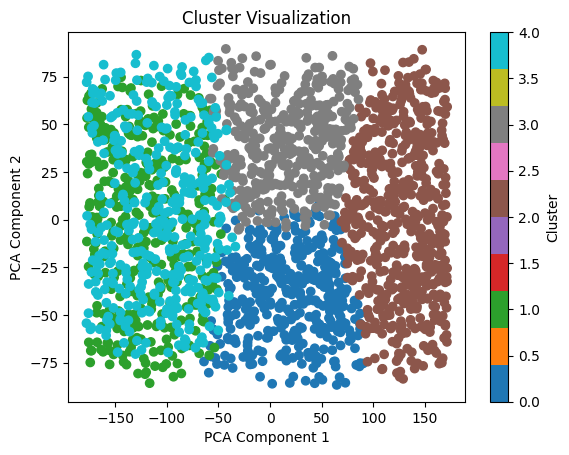

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in best_clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(best_clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab10')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [35]:
import data_reader
import numpy as np
from scipy.stats import mode

# Load data and prepare matrices
# Load data from the Alzheimer's dataset
# Assume column names might have trailing spaces, so strip them
raw_data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')
data = {key.strip(): value for key, value in raw_data.items()}

# Define numerical and categorical columns
num_cols = ['BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL',
    'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
    'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
    'ADL']
cat_cols = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
      'Depression', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
      'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
      'Forgetfulness', 'HeadInjury', 'Smoking', 'Ethnicity', 'Gender',
      'EducationLevel']

# Create matrices for numerical and categorical data
num_matrix = np.vstack(tuple(data[col] for col in num_cols)).T
cat_matrix = np.vstack(tuple(data[col] for col in cat_cols)).T

# Dissimilarity and distance functions
def dissimilarity_score(v1, v2):
    return np.sum(v1 != v2)

def euclidian_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

# Initialize variables
k = 4  # Number of clusters
num_runs = 20  # Number of runs

best_clusters = None
best_prototypes = None
best_score = float('inf')  # Minimize within-cluster distance
best_prototype_index = None
best_starting_indices = None  # To track the best starting indices

# Perform multiple runs
for run in range(num_runs):
    # Randomly initialize prototypes
    prototypes = np.random.randint(0, len(num_matrix), k)
    starting_indices = prototypes.copy()  # Save the initial starting indices
    prototype_index = prototypes
    prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]

    # Initialize clusters
    clusters = [[] for _ in range(k)]

    def assign_cluster(prototypes, clusters, point):
        dissimilarities = []
        for pt in prototypes:
            v_n = num_matrix[point]
            v_c = cat_matrix[point]
            pt_v_n = pt[0]
            pt_v_c = pt[1]
            dissimilarity = dissimilarity_score(pt_v_c, v_c) + euclidian_distance(pt_v_n, v_n)
            dissimilarities.append(dissimilarity)

        dissimilarities = np.array(dissimilarities)
        cluster = np.where(dissimilarities == dissimilarities.min())[0][0]
        clusters[cluster].append((num_matrix[point], cat_matrix[point]))
        return clusters

    def calc_prototype(cluster):
        if len(cluster) == 0:
            return None  # Handle empty cluster case as needed
        
        num_cluster = np.vstack([point[0] for point in cluster])
        num_prototype = np.mean(num_cluster, axis=0)
        cat_cluster = np.vstack([point[1] for point in cluster])
        cat_prototype = mode(cat_cluster, axis=0).mode[0]
        return (num_prototype, cat_prototype)

    # Main k-prototypes algorithm
    while True:
        for i in range(len(num_matrix)):
            clusters = assign_cluster(prototypes, clusters, i)

        # Calculate new prototypes
        new_prototypes = [calc_prototype(cluster) for cluster in clusters]

        # Check convergence
        done = True
        for i in range(len(prototypes)):
            if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
               not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
                done = False
                break
        if done:
            break

        prototypes = new_prototypes
        clusters = [[] for _ in range(k)]

    # Evaluate within-cluster distance
    total_distance = 0
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            num_distance = euclidian_distance(point[0], prototypes[cluster_idx][0])
            cat_distance = dissimilarity_score(point[1], prototypes[cluster_idx][1])
            total_distance += num_distance + cat_distance

    # Update the best solution if this run is better
    if total_distance < best_score:
        best_score = total_distance
        best_clusters = clusters
        best_prototypes = prototypes
        best_prototype_index = prototype_index
        best_starting_indices = starting_indices  # Save the starting indices

# Print the best clustering result
print(f"Best clustering result found after {num_runs} runs:")
print(f"Within-cluster distance: {best_score:.2f}")
for i, cluster in enumerate(best_clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")

# Print the starting indices for reproducibility
print(f"Best starting indices for reproducibility: {best_starting_indices}")


Best clustering result found after 20 runs:
Within-cluster distance: 171619.83
Cluster 1: 655 points
Cluster 2: 418 points
Cluster 3: 638 points
Cluster 4: 438 points
Best starting indices for reproducibility: [ 501 1737  971 1691]


In [37]:
# Reproduce results
# Initialize prototypes using the best starting indices
prototypes = best_starting_indices
#prototypes = [1058,  598,   42, 1106, 1647]
prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]

# Run the k-prototypes algorithm once with these prototypes to reproduce the result
clusters = [[] for _ in range(k)]
while True:
    for i in range(len(num_matrix)):
        clusters = assign_cluster(prototypes, clusters, i)

    # Calculate new prototypes
    new_prototypes = [calc_prototype(cluster) for cluster in clusters]

    # Check convergence
    done = True
    for i in range(len(prototypes)):
        if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
           not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
            done = False
            break
    if done:
        break

    prototypes = new_prototypes
    clusters = [[] for _ in range(k)]

print("Reproduced clustering result:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Reproduced clustering result:
Cluster 1: 655 points
Cluster 2: 418 points
Cluster 3: 638 points
Cluster 4: 438 points


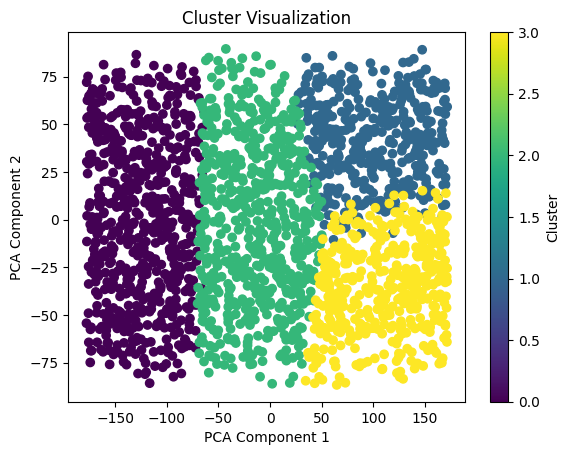

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()